In [835]:
# Import required libraries
import pandas as pd
import numpy as np
import re
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Data

In [477]:
# Import dataset
events = pd.read_excel('~/Downloads/combined_events.xlsx')
events.head(5)

,description,id_satp,relevant_event,multiple_events,internal_conflict,number_casualties,number_injuries,pacification_event,economic_conditions,political_demands,communal_conflict,caste_conflict,naxalite_maoist,organized_crime,islamic_terrorism,note
0,A Communist Party of India-Maoist (CPI-Maoist)...,ID_6103,1,0.0,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN
1,Communist Party of India-Maoist (CPI-Maoist) m...,ID_4707,1,1.0,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN
2,Senior separatist leaders Syed Ali Shah Geelan...,ID_94982,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Opposing Government of Indias (GoI) reported d...,ID_17777,1,0.0,1.0,905,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
4,Cadres of the Communist Party of India-Maoist ...,ID_60843,1,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN


In [478]:
events.shape

(1084, 16)

In [479]:
events.describe()

,relevant_event,multiple_events,internal_conflict,number_injuries,pacification_event,economic_conditions,political_demands,communal_conflict,caste_conflict,naxalite_maoist,organized_crime,islamic_terrorism
count,1084.000000,815.000000,812.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,343.000000
mean,0.677122,0.100613,0.945813,3.810458,0.098039,0.050654,0.155229,0.044118,0.016340,0.331699,0.068627,0.093294
std,0.467792,0.301001,0.226526,57.089501,0.297611,0.219469,0.362419,0.205524,0.126883,0.471209,0.253026,0.291270
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Preprocessing

In [480]:
# Function for processing text
def nlp_pipeline(data):
    # Convert to lower case
    data['description'] = data['description'].str.lower()
    # Remove duplicate values
    data = data.drop_duplicates().reset_index(drop=True)
    row_lst = []
    lem = WordNetLemmatizer()
    stop = stopwords.words('english')
    for i in range(len(data)):
        row = str(data['description'].iloc[i])
        # Remove non-alphanumeric characters
        row = re.sub(r'[^0-9A-Za-z]',  ' ', row)
        # Remove stopwords and lemmatizing
        row = ' '.join([lem.lemmatize(word) for word in row.split() if not word in set(stopwords.words('english'))])
        row_lst.append(row)
    data['description'] = row_lst
    return data

# Function for removing additional words
def remove_words(data, words_to_remove):
    row_lst = []
    for i in range(len(data)):
        row = str(data['description'].iloc[i])
        for word in words_to_remove:
            row = re.sub(word, '', row)
        row_lst.append(row)
    data['description'] = row_lst
    return data

In [481]:
# Clean data
cleaned_events = nlp_pipeline(events)
cleaned_events.head(5)

,description,id_satp,relevant_event,multiple_events,internal_conflict,number_casualties,number_injuries,pacification_event,economic_conditions,political_demands,communal_conflict,caste_conflict,naxalite_maoist,organized_crime,islamic_terrorism,note
0,communist party india maoist cpi maoist comman...,ID_6103,1,0.0,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN
1,communist party india maoist cpi maoist militi...,ID_4707,1,1.0,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN
2,senior separatist leader syed ali shah geelani...,ID_94982,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,opposing government india goi reported decisio...,ID_17777,1,0.0,1.0,905,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
4,cadre communist party india maoist cpi maoist ...,ID_60843,1,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN


## Support Vector Machine for `relevant_event`

### Cross-Validation

In [791]:
# Define function for cross-validation
def cross_validation(kernel, C, gamma, num_features, folds):
    # Split dataset into folds
    kf = KFold(n_splits=folds, shuffle=True)
    accuracy = []
    # SVM model
    SVM = svm.SVC(C=C, kernel=kernel, degree=3, gamma=gamma)
    vectorizer_tf = TfidfVectorizer(max_features=num_features)
    encoder = LabelEncoder()
    X = vectorizer_tf.fit_transform(cleaned_events['description']).toarray()
    X_scaled = preprocessing.scale(X)
    Y = encoder.fit_transform(cleaned_events['relevant_event'])
    # Cross-validation
    for train_idx, valid_idx in kf.split(X):
        split_X_train, split_X_valid = X_scaled[train_idx, :], X_scaled[valid_idx, :]
        split_Y_train, split_Y_valid = Y[train_idx], Y[valid_idx]
        SVM.fit(split_X_train,split_Y_train)
        predictions_SVM = SVM.predict(split_X_valid)
        accuracy.append(accuracy_score(predictions_SVM, split_Y_valid))
    return np.mean(accuracy), np.std(accuracy)

#### 1. Number of Features

First, I'm doing cross-validation to identify the optimal number of features to use in the model. I'm using a linear kernel for now.

In [795]:
# Define function for cross-validation based on number of features
def num_features_cv(min_num_features, max_num_features, interval, kernel, C, gamma):
    num_features = np.array(range(min_num_features, max_num_features, interval))
    folds = np.array(range(2, 6))
    accuracy_cv = pd.DataFrame(columns = ['num_features', 'folds', 'average_cv_accuracy', 'sd_cv_accuracy'])
    for n in num_features:
        for f in folds:
            mean, sd = cross_validation(kernel, C, gamma, n, f)
            accuracy_cv = accuracy_cv.append({'num_features': n, 'folds': f, 'average_cv_accuracy': mean, 'sd_cv_accuracy': sd}, ignore_index=True)
    accuracy_cv['num_features'] = accuracy_cv['num_features'].astype('int')
    accuracy_cv['folds'] = accuracy_cv['folds'].astype('int')
    grouped_features = accuracy_cv.groupby('num_features').mean().drop('folds', axis=1).sort_values(by='average_cv_accuracy', ascending=False).reset_index()
    return accuracy_cv, grouped_features

In [806]:
# Define function for plotting accuracy
def plot_accuracy(x, y, data):
    sns.lmplot(x=x, y=y, data=data)
    plt.show()

In [808]:
# CV for number of features for whole range
accuracy_linear_full, grouped_linear_full = num_features_cv(1, 3001, 10, 'linear', 1.0, 'auto')

In [809]:
grouped_linear_full.head(5)

,num_features,average_cv_accuracy,sd_cv_accuracy
0,31,0.799800,0.021853
1,21,0.793950,0.019693
2,1351,0.786403,0.009975
3,41,0.781934,0.023614
4,1401,0.780909,0.018118


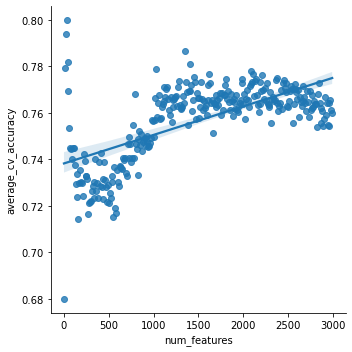

In [810]:
# Plot accuracy for CV on full range of features
plot_accuracy('num_features', 'average_cv_accuracy', grouped_linear_full)

In [797]:
# CV for number of features for 30-100
accuracy_linear_small, grouped_linear_small = num_features_cv(30, 101, 1, 'linear', 1.0, 'auto')

In [803]:
grouped_linear_small.head(5)

,num_features,average_cv_accuracy,sd_cv_accuracy
0,32,0.800831,0.017576
1,31,0.798754,0.019040
2,30,0.797413,0.024821
3,34,0.795005,0.022131
4,37,0.787430,0.017144


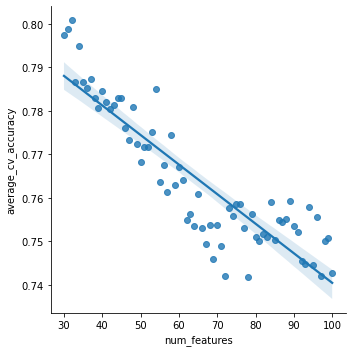

In [807]:
# Plot accuracy for CV on restricted range
plot_accuracy('num_features', 'average_cv_accuracy', grouped_linear_small)

#### 2. Kernel type

Next, I'm repeating the cross-validation using the RBF kernel (as opposed to the linear kernel used in the previous section).

In [811]:
# CV for number of features for whole range
accuracy_rbf_full, grouped_rbf_full = num_features_cv(1, 3001, 10, 'rbf', 1.0, 'auto')

In [812]:
grouped_rbf_full.head(5)

,num_features,average_cv_accuracy,sd_cv_accuracy
0,31,0.807687,0.018708
1,41,0.797380,0.015903
2,111,0.795687,0.013703
3,51,0.790517,0.028689
4,21,0.789163,0.022220


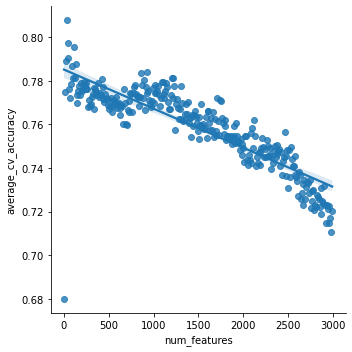

In [813]:
# Plot accuracy for CV on full range of features
plot_accuracy('num_features', 'average_cv_accuracy', grouped_rbf_full)

In [814]:
# CV for number of features for 30-100
accuracy_rbf_small, grouped_rbf_small = num_features_cv(30, 101, 1, 'rbf', 1.0, 'auto')

In [815]:
grouped_rbf_small.head(5)

,num_features,average_cv_accuracy,sd_cv_accuracy
0,32,0.814553,0.015352
1,30,0.809748,0.023023
2,33,0.807704,0.023844
3,35,0.807359,0.022795
4,31,0.804606,0.019837


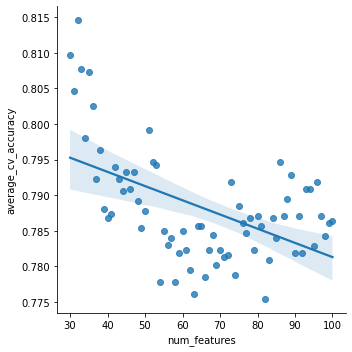

In [816]:
# Plot accuracy for CV on restricted range
plot_accuracy('num_features', 'average_cv_accuracy', grouped_rbf_small)

Results:
- CV doesn't show a significant difference between RBF and linear kernels but RBF is considered better so I'll go with that (plus test accuracy is higher with RBF).
- CV shows that 32 is the ideal number of features.

## Training 

Train the model and compute the testing accuracy using the hyperparameters found using cross-validation.

In [822]:
# Vectorize the data using TFIDF
vectorizer_tf = TfidfVectorizer(max_features=32)
tf = vectorizer_tf.fit_transform(cleaned_events['description'])
tf_scaled = preprocessing.scale(tf.toarray())

In [850]:
# Features selected by TFIDF
vectorizer_tf.vocabulary_

{'communist': 6,
 'party': 20,
 'india': 13,
 'maoist': 15,
 'cpi': 7,
 'cadre': 4,
 'arrested': 3,
 'district': 8,
 'report': 24,
 'said': 25,
 'identified': 12,
 'village': 31,
 'security': 26,
 'force': 9,
 'police': 22,
 'area': 2,
 'recovered': 23,
 'two': 30,
 'government': 10,
 'three': 29,
 'militant': 16,
 'group': 11,
 'chief': 5,
 'minister': 17,
 'state': 27,
 'terrorist': 28,
 'according': 0,
 'one': 19,
 'also': 1,
 'national': 18,
 'killed': 14,
 'people': 21}

- Remove some words?

In [826]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(tf_scaled, cleaned_events['relevant_event'], test_size=0.25, random_state=42)

In [827]:
# Label encoding - transform the outcome variable to a suitable format for classification
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [828]:
# Train the SVM model and use it for prediction
SVM = svm.SVC(C=1, kernel='rbf', degree=3, gamma='auto')
SVM.fit(X_train,y_train)
predictions_SVM = SVM.predict(X_test)

Test accuracy: 84.61538461538461


## Evaluation

In [854]:
print("Test accuracy:", accuracy_score(predictions_SVM, y_test)*100)

Test accuracy: 84.61538461538461


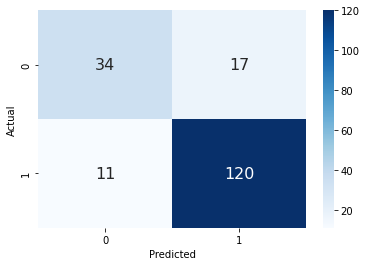

In [847]:
# Confusion matrix to show false positives and negatives
cm = confusion_matrix(y_test, predictions_SVM)
sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'Blues', annot_kws = {'size': 16})
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [849]:
# Computing prediciton and recall
fp = cm[0, 1]
tp = cm[1, 1]
fn = cm[1, 0]
tn = cm[0, 0]
total = fp + tp + fn + tn
# How many relevant events are accurately identified?
recall = tp / (tp + fn)
# How many events identified as relevant are actually relevant?
precision = tp / (tp + fp)

print('False positives:', fp)
print('True positives:', tp)
print('False negatives:', fn)
print('True negatives:', tn)
print('Total:', total)
print()
print('Recall:', recall)
print('Precision:', precision)

False positives: 17
True positives: 120
False negatives: 11
True negatives: 34
Total: 182

Recall: 0.916030534351145
Precision: 0.8759124087591241


----